In [113]:
import pandas as pd
import numpy as np
import re

# Helper functions
def clean_name(name):
    return re.sub(r'\s+', ' ', name).replace('.', '').strip().lower()

def convert_minutes_to_float(minutes_str):
    if isinstance(minutes_str, float):
        return minutes_str
    try:
        minutes, seconds = map(int, str(minutes_str).split(":"))
        return minutes + seconds / 60
    except Exception:
        return np.nan

# Main function
def prepare_defensive_features(data_path, hashmap_path, min_matchup_minutes=500):
    df_matchups_2024 = pd.read_csv(data_path)
    hashmap_df = pd.read_csv(hashmap_path)

    # Step 1: Normalize player names
    df_matchups_2024['player_name'] = (\
        df_matchups_2024['first_name'].fillna("").astype(str) + " " +
        df_matchups_2024['family_name'].fillna("").astype(str)
    ).map(clean_name)

    hashmap_df['player_name'] = hashmap_df['PLAYER'].astype(str).map(clean_name)

    # Step 2: Filter qualified players (MIN > 1800 from hashmap)
    hashmap_df['GP'] = pd.to_numeric(hashmap_df['GP'], errors='coerce').fillna(0)
    hashmap_df['MIN'] = pd.to_numeric(hashmap_df['MIN'], errors='coerce').fillna(0)
    qualified_players_2024 = hashmap_df[(hashmap_df['MIN'] > 1500)]
    qualified_names = qualified_players_2024['player_name'].unique()
    print(qualified_names)

    # Step 3: Apply initial hashmap filter
    df_matchups_2024 = df_matchups_2024[
        df_matchups_2024['player_name'].isin(qualified_names)
    ].copy()

    # Step 4: Convert matchup_minutes column
    if "matchup_minutes" in df_matchups_2024.columns:
        df_matchups_2024["matchup_minutes"] = df_matchups_2024["matchup_minutes"].apply(convert_minutes_to_float)

        # Filter by total matched-up minutes (>= min_matchup_minutes)
        defender_matchup_minutes = df_matchups_2024.groupby("player_name")["matchup_minutes"].sum()
        qualified_by_matchup_minutes = defender_matchup_minutes[defender_matchup_minutes >= min_matchup_minutes].index

        df_matchups_2024 = df_matchups_2024[
            df_matchups_2024["player_name"].isin(qualified_by_matchup_minutes)
        ].copy()

        print(f"✅ Defenders with ≥{min_matchup_minutes} matchup minutes: {len(qualified_by_matchup_minutes)}")

    # Step 5: Convert numeric columns
    numeric_cols = [
        'matchup_field_goals_made', 'matchup_field_goals_attempted', 'matchup_three_pointers_made', 'matchup_three_pointers_attempted', 
        'matchup_free_throws_made', 'matchup_free_throws_attempted', 'matchup_turnovers', 'matchup_blocks', 'help_blocks', 
        'help_field_goals_made', 'help_field_goals_attempted', 'shooting_fouls', 'matchup_minutes_sort', 'matchup_minutes',
        'player_points'
    ]

    for col in numeric_cols:
        if col in df_matchups_2024.columns:
            df_matchups_2024[col] = pd.to_numeric(df_matchups_2024[col], errors='coerce').fillna(0)
        else:
            print(f"⚠️ Warning: Column {col} missing.")

    # Step 6: Create derived features
    df_matchups_2024["minutes_played"] = df_matchups_2024["matchup_minutes_sort"] / 60
    df_matchups_2024["matchup_two_pointers_made"] = df_matchups_2024["matchup_field_goals_made"] - df_matchups_2024["matchup_three_pointers_made"]
    df_matchups_2024["matchup_two_pointers_attempted"] = df_matchups_2024["matchup_field_goals_attempted"] - df_matchups_2024["matchup_three_pointers_attempted"]

    # Step 7: Select final features
    features = df_matchups_2024[[
        "game_id", "person_id", "team_name", "first_name", "family_name", "position",
        "matchups_first_name", "matchups_family_name",
        "matchup_field_goals_made", "matchup_field_goals_attempted",
        "matchup_three_pointers_made", "matchup_three_pointers_attempted",
        "matchup_two_pointers_made", "matchup_two_pointers_attempted",
        "matchup_free_throws_made", "matchup_free_throws_attempted",
        "matchup_turnovers", "matchup_blocks", "help_blocks", 
        "help_field_goals_made", "help_field_goals_attempted",
        "shooting_fouls", "player_points", "matchup_minutes_sort", "matchup_minutes"
    ]].copy()

    return features

        
    

In [114]:
# Ensure the function is defined before using it
def convert_minutes_to_float(minutes_str):
	if isinstance(minutes_str, float):  # If already a float, return as is
		return minutes_str
	try:
		minutes, seconds = map(int, minutes_str.split(':'))
		return minutes + seconds / 60
	except (ValueError, AttributeError):
		return 0  # Handle invalid or missing values

features_from_2024_season_df = prepare_defensive_features(data_path = "matchups_2024 2.csv", hashmap_path = "2024_Player_Hashmap.csv")
features_from_2024_season_df['matchup_minutes'] = features_from_2024_season_df['matchup_minutes_sort'].apply(convert_minutes_to_float)
features_from_2024_season_df


['buddy hield' 'austin reaves' 'bobby portis' 'cason wallace'
 'chet holmgren' 'christian braun' 'domantas sabonis' 'georges niang'
 'harrison barnes' 'jalen green' 'jonas valančiūnas' 'mikal bridges'
 'nickeil alexander-walker' 'obi toppin' 'paul reed' 'payton pritchard'
 'reggie jackson' 'cole anthony' 'donte divincenzo' 'josh hart'
 'michael porter jr' 'naz reid' 'corey kispert' 'dennis schröder'
 'josh giddey' 'paolo banchero' 'pascal siakam' 'anthony edwards'
 'bogdan bogdanovic' 'brook lopez' 'coby white' 'demar derozan'
 'kyle anderson' 'luguentz dort' 'malik beasley' 'nikola jokić'
 "royce o'neale" 'sam hauser' 'tim hardaway jr' 'collin sexton'
 'dejounte murray' 'jordan poole' 'kelly olynyk' 'ochai agbaji'
 'taurean prince' 'jaden ivey' 'jalen brunson' 'jarrett allen'
 'keegan murray' 'klay thompson' 'myles turner' 'tre jones'
 'anthony davis' 'ayo dosunmu' "d'angelo russell" 'derrick jones jr'
 'grant williams' 'herbert jones' 'jabari smith jr' 'jusuf nurkic'
 'kentavious cal

,game_id,person_id,team_name,first_name,family_name,position,matchups_first_name,matchups_family_name,matchup_field_goals_made,matchup_field_goals_attempted,...,matchup_free_throws_attempted,matchup_turnovers,matchup_blocks,help_blocks,help_field_goals_made,help_field_goals_attempted,shooting_fouls,player_points,matchup_minutes_sort,matchup_minutes
0,22400001,1627759,Celtics,Jaylen,Brown,F,Clint,Capela,0,0,...,0,0,0,0,0,0,0,0,34.0,34.0
1,22400001,1627759,Celtics,Jaylen,Brown,F,Dyson,Daniels,3,4,...,2,2,0,0,0,0,1,7,177.1,177.1
2,22400001,1627759,Celtics,Jaylen,Brown,F,Jalen,Johnson,7,13,...,4,3,1,0,0,0,2,20,470.7,470.7
3,22400001,1627759,Celtics,Jaylen,Brown,F,Garrison,Mathews,1,1,...,0,0,0,0,0,0,0,2,41.1,41.1
4,22400001,1627759,Celtics,Jaylen,Brown,F,Larry,Nance Jr.,2,3,...,0,0,0,0,0,0,0,4,47.2,47.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231921,22401230,1627832,Rockets,Fred,VanVleet,G,Ajay,Mitchell,0,0,...,0,0,0,0,0,0,0,0,1.4,1.4
231922,22401230,1627832,Rockets,Fred,VanVleet,G,Cason,Wallace,0,0,...,2,0,0,0,0,0,1,1,118.3,118.3
231923,22401230,1627832,Rockets,Fred,VanVleet,G,Aaron,Wiggins,0,0,...,0,0,0,0,0,0,0,0,26.4,26.4
231924,22401230,1627832,Rockets,Fred,VanVleet,G,Jalen,Williams,2,2,...,0,1,0,0,0,0,0,5,84.8,84.8


[0]	validation_0-logloss:0.59878
[1]	validation_0-logloss:0.55555
[2]	validation_0-logloss:0.51956
[3]	validation_0-logloss:0.48433
[4]	validation_0-logloss:0.45234
[5]	validation_0-logloss:0.42531
[6]	validation_0-logloss:0.40721
[7]	validation_0-logloss:0.38180
[8]	validation_0-logloss:0.35835
[9]	validation_0-logloss:0.33848
[10]	validation_0-logloss:0.32403
[11]	validation_0-logloss:0.30656
[12]	validation_0-logloss:0.28864
[13]	validation_0-logloss:0.27354
[14]	validation_0-logloss:0.26234
[15]	validation_0-logloss:0.24743
[16]	validation_0-logloss:0.23769
[17]	validation_0-logloss:0.22865
[18]	validation_0-logloss:0.21595
[19]	validation_0-logloss:0.20404
[20]	validation_0-logloss:0.19286
[21]	validation_0-logloss:0.18238
[22]	validation_0-logloss:0.17252
[23]	validation_0-logloss:0.16700
[24]	validation_0-logloss:0.16117
[25]	validation_0-logloss:0.15255
[26]	validation_0-logloss:0.14522
[27]	validation_0-logloss:0.13753
[28]	validation_0-logloss:0.13029
[29]	validation_0-loglos

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:01:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[95]	validation_0-logloss:0.00755
[96]	validation_0-logloss:0.00742
[97]	validation_0-logloss:0.00707
[98]	validation_0-logloss:0.00673
[99]	validation_0-logloss:0.00642
[100]	validation_0-logloss:0.00613
[101]	validation_0-logloss:0.00584
[102]	validation_0-logloss:0.00557
[103]	validation_0-logloss:0.00532
[104]	validation_0-logloss:0.00523
[105]	validation_0-logloss:0.00515
[106]	validation_0-logloss:0.00491
[107]	validation_0-logloss:0.00469
[108]	validation_0-logloss:0.00448
[109]	validation_0-logloss:0.00427
[110]	validation_0-logloss:0.00408
[111]	validation_0-logloss:0.00391
[112]	validation_0-logloss:0.00373
[113]	validation_0-logloss:0.00356
[114]	validation_0-logloss:0.00341
[115]	validation_0-logloss:0.00326
[116]	validation_0-logloss:0.00321
[117]	validation_0-logloss:0.00317
[118]	validation_0-logloss:0.00303
[119]	validation_0-logloss:0.00290
[120]	validation_0-logloss:0.00277
[121]	validation_0-logloss:0.00274
[122]	validation_0-logloss:0.00262
[123]	validation_0-loglos

<Figure size 1000x600 with 0 Axes>

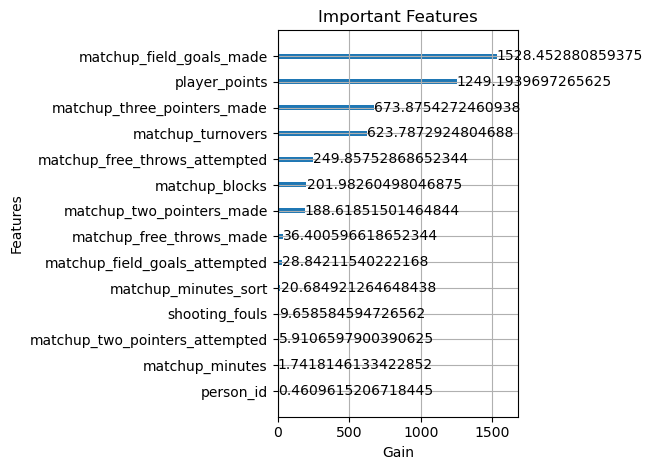

Generating SHAP values...


 97%|=================== | 17304/17809 [00:34<00:00]       

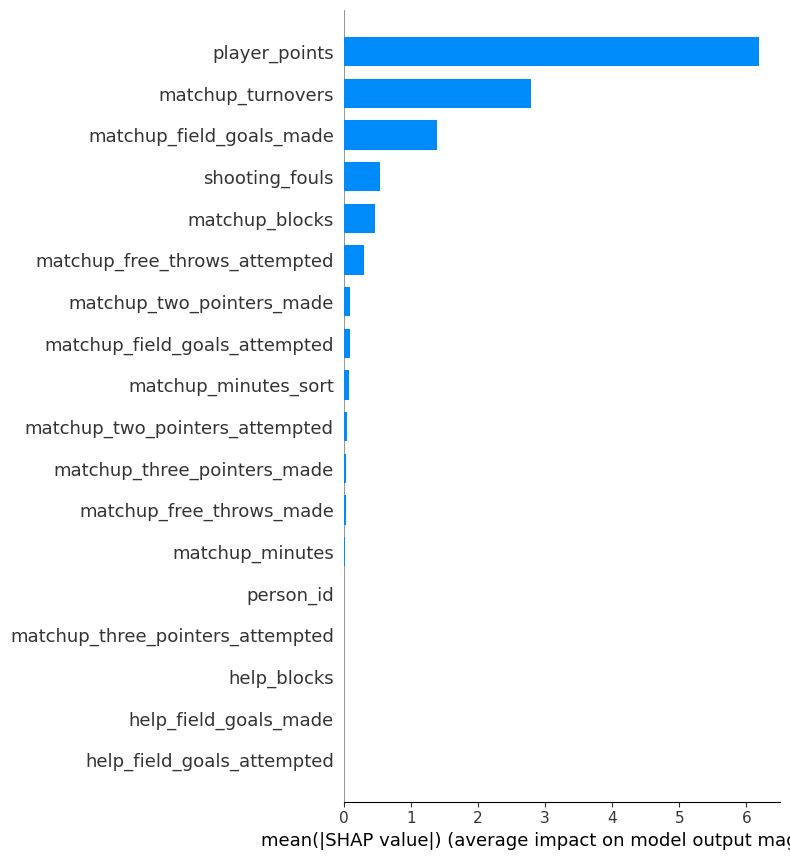

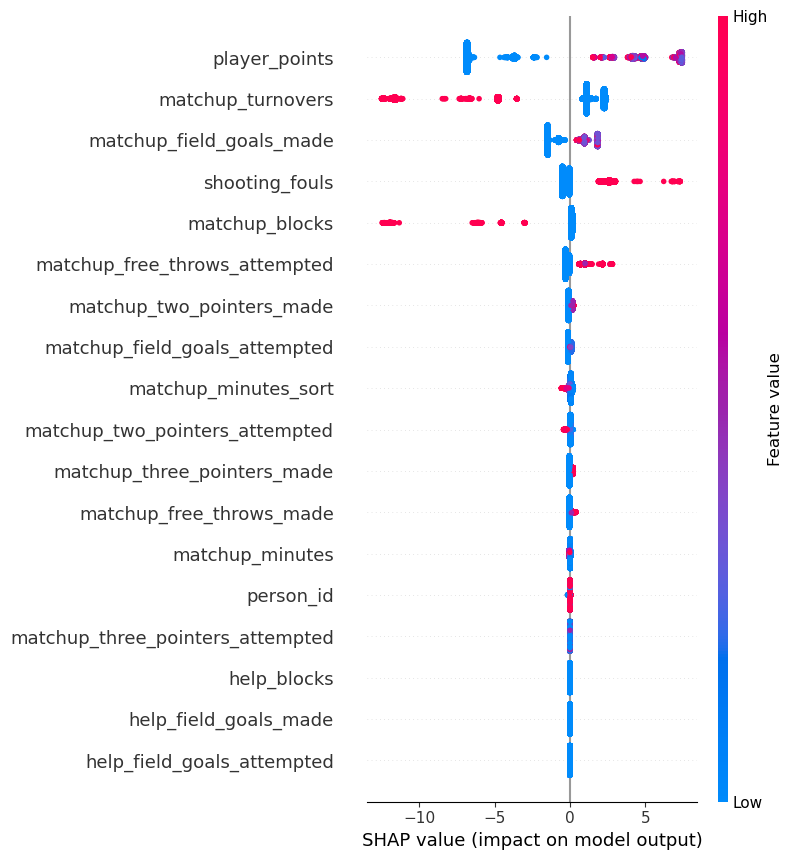


Top Defenders by Average Scoring Probability:
     first_name       family_name position  avg_scoring_probability  \
121     Nickeil  Alexander-Walker        F                 0.000127   
94        Mikal           Bridges        F                 0.105353   
141        Josh             Green        G                 0.129063   
62        Caris            LeVert        F                 0.142872   
92       Dillon            Brooks        G                 0.153883   
..          ...               ...      ...                      ...   
42       Andrew           Wiggins        G                 0.363667   
159     Alperen            Sengun        F                 0.363692   
89      Derrick             White        G                 0.366825   
83           OG           Anunoby        F                 0.368397   
30   Kentavious     Caldwell-Pope        F                 0.368431   

     possessions  
121          787  
94           773  
141          631  
62           604  
92   

first_name,family_name,position,avg_scoring_probability,possessions
Nickeil,Alexander-Walker,F,0.000127,787
Mikal,Bridges,F,0.105353,773
Josh,Green,G,0.129063,631
Caris,LeVert,F,0.142872,604
Dillon,Brooks,G,0.153883,699
Jaime,Jaquez Jr.,G,0.166706,592
Dorian,Finney-Smith,G,0.200032,594
Ochai,Agbaji,G,0.200060,595
Josh,Green,F,0.202709,631
Jeremy,Sochan,C,0.204149,502


In [122]:
%matplotlib inline

import pandas as pd 
import numpy as np 
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split 
from sklearn.metrics import log_loss, roc_auc_score, mean_absolute_error 
from IPython.display import display, HTML
import shap
import matplotlib.pyplot as plt 

def train_defensive_classifier_with_logic(df, test_size = 0.2, random_state = 42): 
    # This trains an XGBoost classifier using basketball-specific defensive logic
    # Predicts the probability of an offensive player scoring (1) or not scoring (0) based on defensive features
    
    # Step 1: Derive target based on game logic
    def derive_scoring_event(row): 
       help_fga = row.get("help_field_goals_attempted", 0)
       help_fgm = row.get("help_field_goals_made", 0)
       
       help_stop = (help_fga > 0 and help_fgm == 0)
       
       defensive_stop = (
           row.get("matchup_turnovers", 0) > 0 or
           row.get("help_blocks", 0) > 0 or
           row.get("matchup_blocks", 0) > 0 or
           help_stop or
           (
                row.get("matchup_field_goals_made", 0) == 0 and
                row.get("matchup_free_throws_made", 0) == 0 and 
                row.get("shooting_fouls", 0) == 0
           )  
       )
       
       return 0 if defensive_stop else 1
    
    df['scoring_event'] = df.apply(derive_scoring_event, axis = 1)
    
    # Step 2: Drop rows without a valid label 
    df = df.dropna(subset = ['scoring_event'])
    
    
    # Step 3: Filter input features (remove IDs and leakage-prone columns)
    meta_cols = ["game_id", "team_name", "first_name", "family_name", "position", "matchups_first_name", "matchups_family_name"]
    feature_cols = [col for col in df.columns if col not in meta_cols + ['scoring_event']]
    
    X = df[feature_cols]
    y = df['scoring_event']
    
    # Step 4: Train-test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = random_state)
    
    # Step 4: Train XGBoost Regressor 
    final_model = XGBClassifier(
        n_estimators = 500, 
        learning_rate = 0.05, 
        max_depth = 5, 
        subsample = 0.8, 
        colsample_bytree = 0.8, 
        reg_alpha = 1.0, 
        reg_lambda = 1.0,
        random_state = random_state, 
        n_jobs = -1, 
        tree_method = 'hist', # Use 'hist' for faster training and large datasets
        eval_metric = 'logloss',
        use_label_encoder = False, 
        objective = 'binary:logistic'
    )
    final_model.fit(
        X_train, y_train, 
        eval_set=[(X_test, y_test)], 
        verbose=True)
    
    # Step 6: Evaluate the model 
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]
    logloss_score = log_loss(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print("\n Model Trained:")
    print(f"Log Loss: {logloss_score:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    # Step 6: Feature Importance Visualization 
    plt.figure(figsize = (10, 6))
    plot_importance(final_model, max_num_features = 15, importance_type = 'gain', title = 'Important Features', xlabel = 'Gain')
    plt.tight_layout()
    plt.show()
    
    # Step 7: SHAP Values
    print("Generating SHAP values...")
    explainer = shap.Explainer(final_model, X_train) 
    shap_values = explainer(X_test)
    
    shap.summary_plot(shap_values, X_test, plot_type = "bar", show = True)
    shap.summary_plot(shap_values, X_test, show = True)
    
    # Step 8: Defender Scoring Probability - the lower the score, the better the defender
    df["scoring_probability"] = final_model.predict_proba(X[feature_cols])[:, 1]

    # Group by unique defender identity with context
    defender_scores_df = (
        df.groupby(['person_id', 'first_name', 'family_name', 'position'])['scoring_probability']
        .mean()
        .reset_index()
        .rename(columns={'scoring_probability': 'avg_scoring_probability'})
    )

    # Add total possessions defended
    defender_possessions = df.groupby('person_id').size().reset_index(name='possessions')
    defender_scores_df = defender_scores_df.merge(defender_possessions, on='person_id', how='left')

    # Sort by best defenders (lowest scoring probability allowed)
    defender_scores_df = defender_scores_df.sort_values(by='avg_scoring_probability')

    # Display top 50 defenders
    print("\nTop Defenders by Average Scoring Probability:")
    print(defender_scores_df[['first_name', 'family_name', 'position', 'avg_scoring_probability', 'possessions']].head(100))
    display(HTML(defender_scores_df[['first_name', 'family_name', 'position', 'avg_scoring_probability', 'possessions']].head(200).to_html(index=False, max_rows = 500, max_cols = 5, notebook = True)))

    return final_model, defender_scores_df, shap_values, X_test, y_test


# Train the model with the updated DataFrame
# Filter players with at least 1000 minutes before training
filtered_df = features_from_2024_season_df
model, defender_scores_df, shap_values, X_test, y_test = train_defensive_classifier_with_logic(filtered_df)

